In [15]:
!pip install requests pandas --quiet
!pip install yfinance pandas requests --quiet

In [16]:
import os
JQUANTS_TOKEN = os.environ.get("JQUANTS_TOKEN")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.8 MB/s eta 0:00:00
東証4桁の銘柄コードを入力してください（例: 7224）: 7224
信用取引関連特徴量を使用しますか？（y/n）: n


[*********************100%***********************]  1 of 1 completed
<ipython-input-35-2ab0b880df31>:84: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["RSI14"].fillna(50, inplace=True)



=== 最新10営業日の各種指標＆信用関連データ ===
Price         Open    High     Low   Close  Volume     MA5     MA25         MA75      RSI14       MACD  SignalLine  MACD_hist  Volume_pct_change  VolumeRatio_5_20  VolumeSurgeScore
Date                                                                                                                                                                                
2025-05-20  1360.0  1370.0  1351.0  1355.0  149500  1357.2  1321.84  1347.265877  53.649236   9.625129    5.439829   4.185300          -0.059748          0.838488         -0.564144
2025-05-21  1362.0  1368.0  1348.0  1348.0  130800  1352.0  1324.80  1347.550334  51.956784   8.823383    6.116540   2.706843          -0.125084          0.761372         -0.741679
2025-05-22  1341.0  1356.0  1337.0  1350.0  176800  1352.6  1327.72  1347.926922  52.418640   8.254227    6.544077   1.710150           0.351682          0.777142         -0.293583
2025-05-23  1365.0  1417.0  1361.0  1387.0  356100  1359.2  1331.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:36:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)




--- 7224.T の最新データに基づく各モデルの上昇確率予測 (色分け表示) ---


<ipython-input-35-2ab0b880df31>:260: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df_predictions = df_predictions.style.applymap(


,5日後 上昇確率(%),20日後 上昇確率(%)
モデル,,
LogReg,52.7%,50.8%
RF,63.0%,85.0%
XGB,96.4%,97.6%



--- 7224.T のHMM 最新データ分析 ---
  推定された現在の状態: State1
  この状態における過去の当日リターン正の傾向: 56.8%


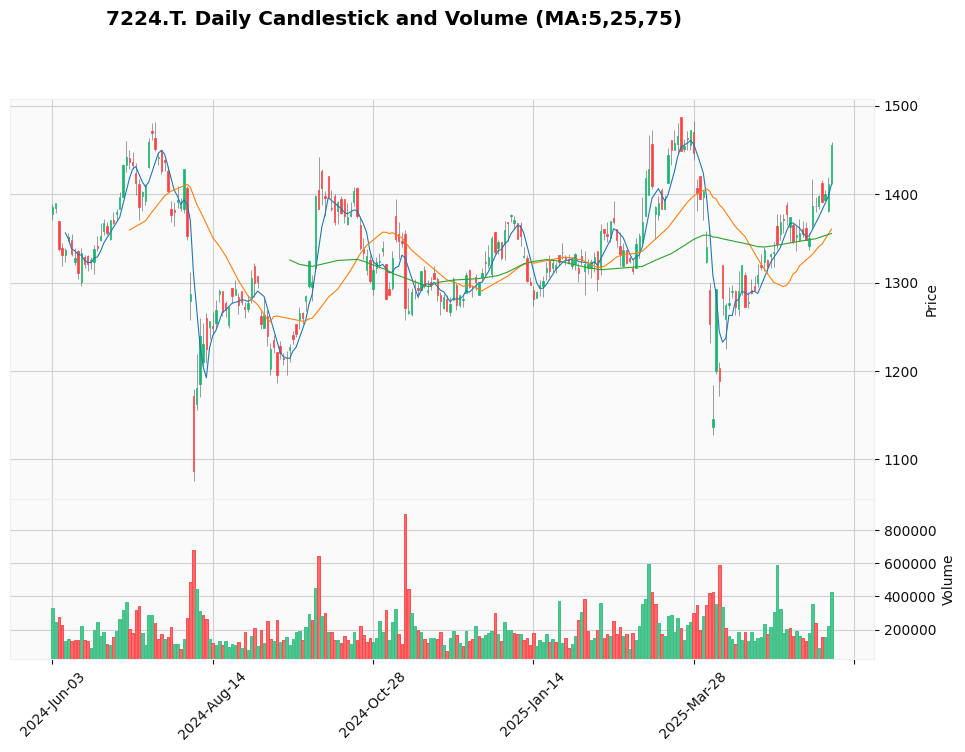

In [35]:
# ======================================
# 必要ライブラリのインストール（Colab/初回のみ）
# ======================================
!pip install yfinance pandas requests mplfinance scikit-learn xgboost hmmlearn --quiet

# ======================================
# 1) ライブラリのインポート
# ======================================
import yfinance as yf
import pandas as pd
import numpy as np
import mplfinance as mpf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from hmmlearn.hmm import GaussianHMM
from IPython.display import HTML

# ======================================
# 2) ユーザー入力：銘柄コードと信用利用フラグ
# ======================================
ticker4    = input("東証4桁の銘柄コードを入力してください（例: 7224）: ").strip()
use_credit = input("信用取引関連特徴量を使用しますか？（y/n）: ").strip().lower() == 'y'

# ======================================
# 3) 株価データを yfinance で取得
# ======================================
ticker = f"{ticker4}.T"
df_raw = yf.download(ticker, period="1y", interval="1d")[["Open", "High", "Low", "Close", "Volume"]].dropna()

# マルチインデックスなら平坦化
if isinstance(df_raw.columns, pd.MultiIndex):
    df_raw.columns = df_raw.columns.get_level_values(0)

df = df_raw.copy()
df.index = pd.to_datetime(df.index)

# ======================================
# 4) ダミー信用残データの生成（オプション）
# ======================================
if use_credit:
    weekly_dates     = pd.date_range(start=df.index.min(), end=df.index.max(), freq='W-MON')
    np.random.seed(0)
    buy_dummy        = (df["Close"].mean() * np.random.uniform(0.5, 1.5, size=len(weekly_dates))).astype(int)
    sell_dummy       = (df["Close"].mean() * np.random.uniform(0.2, 1.0, size=len(weekly_dates))).astype(int)
    df_credit_weekly = pd.DataFrame({
        "Date":              weekly_dates,
        "CreditBuyBalance":  buy_dummy,
        "CreditSellBalance": sell_dummy
    }).set_index("Date")
    df_credit_daily  = df_credit_weekly.reindex(df.index).ffill().fillna(0).shift(2)
    df["CreditBuyBalance"]  = df_credit_daily["CreditBuyBalance"]
    df["CreditSellBalance"] = df_credit_daily["CreditSellBalance"]
else:
    df["CreditBuyBalance"]  = np.nan
    df["CreditSellBalance"] = np.nan

# ======================================
# 5) テクニカル指標と信用関連特徴量の計算
# ======================================
# リターン・ボラティリティ
df["Ret1"]            = df["Close"].pct_change(1)
df["Ret5"]            = df["Close"].pct_change(5)
df["Ret20"]           = df["Close"].pct_change(20)
df["Vol5"]            = df["Ret1"].rolling(5).std()
df["Vol20"]           = df["Ret1"].rolling(20).std()

# 移動平均
df["MA5"]             = df["Close"].rolling(window=5).mean()
df["MA25"]            = df["Close"].rolling(window=25).mean()
df["MA75"]            = df["Close"].rolling(window=75).mean()

# RSI
delta                 = df["Close"].diff()
up                    = delta.clip(lower=0)
down                  = -delta.clip(upper=0)
roll_up               = up.ewm(com=13, min_periods=14, adjust=False).mean()
roll_down             = down.ewm(com=13, min_periods=14, adjust=False).mean()
rs                    = roll_up / roll_down.replace(0, 1e-9)
df["RSI14"]           = 100 - (100 / (1 + rs))
df["RSI14"].fillna(50, inplace=True)

# MACD
ema_short_span        = 12
ema_long_span         = 26
signal_span           = 9
df["EMA_short"]       = df["Close"].ewm(span=ema_short_span, adjust=False).mean()
df["EMA_long"]        = df["Close"].ewm(span=ema_long_span, adjust=False).mean()
df["MACD"]            = df["EMA_short"] - df["EMA_long"]
df["SignalLine"]      = df["MACD"].ewm(span=signal_span, adjust=False).mean()
df["MACD_hist"]       = df["MACD"] - df["SignalLine"]

# 出来高関連
df["Volume_pct_change"]= df["Volume"].pct_change(1)
df["Volume_MA5"]      = df["Volume"].rolling(window=5).mean()
df["Volume_MA20"]     = df["Volume"].rolling(window=20).mean()
df["VolumeRatio_5_20"]= df["Volume_MA5"] / (df["Volume_MA20"] + 1e-6)
df["VolumeStd20"]     = df["Volume"].rolling(window=20).std()
df["VolumeSurgeScore"] = (df["Volume"] - df["Volume_MA20"]) / (df["VolumeStd20"] + 1e-6)

# 信用関連特徴量
if use_credit:
    df["CreditBuyChange"]  = df["CreditBuyBalance"].diff()
    df["CreditSellChange"] = df["CreditSellBalance"].diff()
    df["CreditRatio"]      = df["CreditBuyBalance"] / (df["CreditSellBalance"] + 1e-6)
    avg_vol5               = df["Volume"].rolling(window=5).mean() + 1e-6
    df["BuyTurnoverDays"]  = df["CreditBuyBalance"]  / avg_vol5
    df["SellTurnoverDays"] = df["CreditSellBalance"] / avg_vol5

# ======================================
# 6) 目的変数の作成 (5日後/20日後)
# ======================================
df["Target5"]  = (df["Close"].shift(-5)  > df["Close"]).astype(int)
df["Target20"] = (df["Close"].shift(-20) > df["Close"]).astype(int)

# ======================================
# 7) 最新10営業日のテーブル表示
# ======================================
cols_to_show = [
    "Open","High","Low","Close","Volume",
    "MA5","MA25","MA75","RSI14","MACD","SignalLine","MACD_hist",
    "Volume_pct_change","VolumeRatio_5_20","VolumeSurgeScore"
]
if use_credit:
    cols_to_show += [
        "CreditBuyBalance","CreditSellBalance",
        "CreditBuyChange","CreditSellChange","CreditRatio",
        "BuyTurnoverDays","SellTurnoverDays"
    ]

display_df = df[cols_to_show].iloc[-10:].copy()
print("\n=== 最新10営業日の各種指標＆信用関連データ ===")
print(display_df.to_string())

# ======================================
# 8) モデル学習と評価 (5日後/20日後)
# ======================================
features = [
    "Ret1","Ret5","Ret20","Vol5","Vol20",
    "MA5","MA25","MA75","RSI14","MACD","SignalLine","MACD_hist",
    "Volume_pct_change","VolumeRatio_5_20","VolumeSurgeScore"
]
if use_credit:
    features += [
        "CreditBuyChange","CreditSellChange","CreditRatio",
        "BuyTurnoverDays","SellTurnoverDays"
    ]

all_cols = features + ["Target5", "Target20"]
df_model = df.dropna(subset=all_cols).copy()

X_raw = df_model[features].copy()
y5     = df_model["Target5"].copy()
y20    = df_model["Target20"].copy()

scaler    = StandardScaler()
X_scaled  = scaler.fit_transform(X_raw)
X_train, X_test, y5_train, y5_test, y20_train, y20_test = train_test_split(
    X_scaled, y5, y20, test_size=0.2, shuffle=False
)

# ロジスティック回帰
tscv       = TimeSeriesSplit(n_splits=5)
logreg_5d  = LogisticRegressionCV(cv=tscv, max_iter=2000, random_state=42,
                                  scoring="roc_auc", class_weight="balanced")
logreg_20d = LogisticRegressionCV(cv=tscv, max_iter=2000, random_state=42,
                                  scoring="roc_auc", class_weight="balanced")
logreg_5d.fit(X_train, y5_train)
logreg_20d.fit(X_train, y20_train)

# ランダムフォレスト
rf_5d  = RandomForestClassifier(n_estimators=100, random_state=42,
                                class_weight="balanced", n_jobs=-1)
rf_20d = RandomForestClassifier(n_estimators=100, random_state=42,
                                class_weight="balanced", n_jobs=-1)
rf_5d.fit(X_train, y5_train)
rf_20d.fit(X_train, y20_train)

# XGBoost
scale_pos_weight_5d  = (y5_train == 0).sum()  / (y5_train == 1).sum()  if (y5_train == 1).sum()  > 0 else 1
scale_pos_weight_20d = (y20_train == 0).sum() / (y20_train == 1).sum() if (y20_train == 1).sum() > 0 else 1
xgb_5d  = XGBClassifier(eval_metric="logloss", use_label_encoder=False,
                        random_state=42, scale_pos_weight=scale_pos_weight_5d)
xgb_20d = XGBClassifier(eval_metric="logloss", use_label_encoder=False,
                        random_state=42, scale_pos_weight=scale_pos_weight_20d)
xgb_5d.fit(X_train, y5_train)
xgb_20d.fit(X_train, y20_train)

# 評価と prediction_proba_list の作成
prediction_proba_list = []
models_5d = {"LogReg": logreg_5d, "RF": rf_5d, "XGB": xgb_5d}
models_20d = {"LogReg": logreg_20d, "RF": rf_20d, "XGB": xgb_20d}

for name in models_5d:
    proba_5d  = models_5d[name].predict_proba(X_test)[0][1] * 100 if hasattr(models_5d[name], "predict_proba")  else np.nan
    proba_20d = models_20d[name].predict_proba(X_test)[0][1] * 100 if hasattr(models_20d[name], "predict_proba") else np.nan
    prediction_proba_list.append({
        'モデル': name,
        '5日後 上昇確率(%)': proba_5d,
        '20日後 上昇確率(%)': proba_20d
    })

# ======================================
# 9) HMM（二状態モデル）の学習と最新状態推定
# ======================================
hmm_model_trained = False
hmm_latest_analysis = {"HMM 現在の状態": None, "状態別 当日リターン正の傾向(%)": np.nan}
hmm_obs_features_names = ["Ret1", "Volume_pct_change"]

if all(f in X_raw.columns for f in hmm_obs_features_names):
    X_hmm = X_raw[hmm_obs_features_names].values
    if X_hmm.shape[0] > 1 and not np.all(np.isnan(X_hmm)):
        try:
            hmm = GaussianHMM(n_components=2, covariance_type="diag", n_iter=100, random_state=42)
            hmm.fit(X_hmm[:-len(X_test)])  # 訓練データ期間
            hmm_model_trained = True

            # 最新データの状態推定
            last_obs = X_raw[hmm_obs_features_names].iloc[[-1]].values
            last_state = hmm.predict(last_obs)[0]
            hmm_latest_analysis["HMM 現在の状態"] = f"State{last_state}"

            # 各状態における「当日リターン>0」の割合
            states_all = hmm.predict(X_hmm)
            df_states = pd.DataFrame({
                'State': states_all,
                'Ret1': X_raw["Ret1"].values
            }, index=X_raw.index)
            if last_state in df_states["State"].unique():
                prob_positive = (df_states[df_states["State"] == last_state]["Ret1"] > 0).mean() * 100
                hmm_latest_analysis["状態別 当日リターン正の傾向(%)"] = prob_positive
        except:
            pass

# ======================================
# 10) 予測確率の色分け付きテーブル表示
# ======================================
print(f"\n\n--- {ticker} の最新データに基づく各モデルの上昇確率予測 (色分け表示) ---")
if prediction_proba_list:
    df_predictions = pd.DataFrame(prediction_proba_list).set_index('モデル')

    def highlight_proba_cells(val):
        if pd.isnull(val):
            return 'background-color: white; color: black'
        color = 'black'
        bgcolor = 'white'
        if val >= 70:
            bgcolor = '#90EE90'   # 明るい緑 (強い上昇予測)
        elif val >= 60:
            bgcolor = '#C8E6C9'   # 薄い緑 (やや強い上昇予測)
        elif val <= 30:
            bgcolor = '#FFB6C1'   # 明るい赤 (強い下落予測/非上昇)
        elif val <= 40:
            bgcolor = '#FFCDD2'   # 薄い赤 (やや強い下落予測/非上昇)
        return f'background-color: {bgcolor}; color: {color}; text-align: center;'

    styled_df_predictions = df_predictions.style.applymap(
        highlight_proba_cells,
        subset=['5日後 上昇確率(%)', '20日後 上昇確率(%)']
    ).format({
        '5日後 上昇確率(%)': '{:.1f}%',
        '20日後 上昇確率(%)': '{:.1f}%'
    }).set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ])

    display(HTML(styled_df_predictions.to_html(escape=False)))
else:
    print("予測確率がありません。")

if hmm_model_trained:
    print(f"\n--- {ticker} のHMM 最新データ分析 ---")
    print(f"  推定された現在の状態: {hmm_latest_analysis['HMM 現在の状態']}")
    assoc_prob_hmm_val = hmm_latest_analysis.get('状態別 当日リターン正の傾向(%)', None)
    if pd.notnull(assoc_prob_hmm_val):
        print(f"  この状態における過去の当日リターン正の傾向: {assoc_prob_hmm_val:.1f}%")
    else:
        print("  この状態における過去の当日リターン正の傾向: N/A または計算不能")

# ======================================
# 11) ローソク足＋出来高＋移動平均のプロット（英語表記）
# ======================================
plot_df = df[["Open", "High", "Low", "Close", "Volume"]].dropna().astype(float)
mpf.plot(
    plot_df,
    type='candle',
    mav=(5, 25, 75),
    volume=True,
    title=f"{ticker}. Daily Candlestick and Volume (MA:5,25,75)",
    style='yahoo',
    figsize=(12, 8)
)


1. データ取得・前処理
ユーザー入力

「東証4桁の銘柄コード」をテキストで受け取ります（例：7224 → 7224.T を使う）。

「信用取引関連特徴量を使うかどうか」を y/n で選択できます（Colab上ではダミー生成ですが、ロジックは組み込まれています）。

yfinance で株価を取得

サンプルでは直近「1 年分」の日次データ (Open, High, Low, Close, Volume) をダウンロードします。

もし MultiIndex になっていたら、トップレベル（例："Price"）を削除して、純粋に５つのカラムをフラットにします。

（オプション）ダミー信用残の作成 → 日次展開・シフト

use_credit=True の場合のみ、週次（月曜）ベースで「信用買い残」「信用売り残」のダミーデータを生成。

生成後に毎営業日へ ffill（前日までの値を引き継ぐ）し、さらに「発表遅れ分」を想定して 2 営業日分シフトさせます。

最終的に df["CreditBuyBalance"], df["CreditSellBalance"] が日次で埋まる形になります。

2. 特徴量エンジニアリング（テクニカル＋信用関連）
テクニカル指標

リターン系

Ret1：1 日リターン（前日比）。

Ret5：5 日リターン（5 日前比）。

Ret20：20 日リターン（20 日前比）。

ボラティリティ系

Vol5：直近 5 営業日のリターン標準偏差。

Vol20：直近 20 営業日のリターン標準偏差。

移動平均

MA5, MA25, MA75：それぞれ 5 日、25 日、75 日の単純移動平均（SMA）。

RSI（Relative Strength Index）

RSI14：14 日間の RSI（上昇幅・下落幅の指数移動平均を使った算出）。

初期 NaN は中間値 50 で埋めています。

MACD 系

EMA_short（12 日指数移動平均）、EMA_long（26 日 EMA）を計算し、
MACD = EMA_short - EMA_long
SignalLine = MACD の 9 日 EMA
MACD_hist = MACD - SignalLine

出来高関連

Volume_pct_change：当日出来高の前日比。

Volume_MA5, Volume_MA20：それぞれ 5 日・20 日の出来高移動平均。

VolumeRatio_5_20 = Volume_MA5 / Volume_MA20

VolumeStd20 = 20 日間の出来高標準偏差

VolumeSurgeScore = (当日Volume - Volume_MA20) / VolumeStd20
→ 出来高が過去平均に対してどの程度サージ（急増）しているかのスコア。

（オプション）信用関連特徴量

CreditBuyChange / CreditSellChange：それぞれの信用残の当日差分。

CreditRatio = CreditBuyBalance / (CreditSellBalance + 1e-6)（信用買い／売りの比率）

BuyTurnoverDays = CreditBuyBalance / (直近5日平均出来高)

SellTurnoverDays = CreditSellBalance / (直近5日平均出来高)
→ いずれも「信用残と出来高を組み合わせて需給回転日数をイメージする」指標です。

3. 目的変数の作成
Target5：当日終値より「5 営業日後の終値」が高いか（1 / 0 二値）。

Target20：当日終値より「20 営業日後の終値」が高いか（1 / 0 二値）。

この例では、以降「5 日後予測（Target5）」をメインにモデル学習していますが、
コード中では 20 日後 (Target20) の予測も計算可能なように枠組みを残しています。

4. 学習データの準備
特徴量リストの定義

「テクニカル指標」＋（オプションで）「信用関連特徴量」をまとめた features リストを作る。

NaN の行を除去して df_model を作成

df.dropna(subset=features + ["Target5"]) とすることで、特徴量とターゲットが揃っている行だけ残す。

X_raw（特徴量行列） と y5（5日後二値ターゲット）を切り出し

標準化 + 時系列分割

StandardScaler で標準化（平均 0・分散 1 にスケーリング）。

train_test_split(test_size=0.2, shuffle=False) で、時系列を保ったまま 直近 20% をテストセット に。

5. モデル学習と評価（5 日後予測を例示）
ロジスティック回帰（LogisticRegressionCV）

cv=TimeSeriesSplit(n_splits=5) を指定し、時系列分割で交差検証しつつ最適な正則化パラメータを探索。

scoring="roc_auc", class_weight="balanced" により、ROC AUC を最大化かつクラス不均衡を考慮。

ランダムフォレスト（RandomForestClassifier）

n_estimators=100, class_weight="balanced" でインスタンス化。デフォルトの max_depth 等はそのまま。

XGBoost（XGBClassifier）

scale_pos_weight = (負クラス数/正クラス数) を算出して渡すことで、陽性サンプルが少ない場合の不均衡を補正。

eval_metric="logloss", use_label_encoder=False として学習。

テストセットで評価

Accuracy, ROC AUC, Precision, Recall, F1 を計算し、pd.DataFrame でまとめています。

精度だけでなく、陽性クラス（「株価上昇＝1」）の適合率・再現率・F1 を確認するのがポイント。

6. 最新データポイントでの確率予測
テストセットの最後のサンプル（最新ポイント）を使って、

各モデルが「5 日後上昇と予測する確率」を predict_proba(...)[:,1] * 100 の形で取得し、パーセンテージ表示。

この結果を prediction_proba_list というリストに集約し、

あとで色分けした “5日後/20日後上昇確率のテーブル” として表示できるようにしてあります。

7. HMM（隠れマルコフモデル）による解析（オプション）
観測特徴量を選択

例として ["Ret1", "Volume_pct_change"] を HMM の観測変数として使う。

学習

GaussianHMM(n_components=2) で 2 状態モデルを構築・学習。

テストデータに適用して状態を推定

テストセットの観測データに対し hmm_model.predict(...) を呼び出し、各行がどちらの「隠れ状態」に属するかを予測。

各状態で「当日リターンが正（>0）となる確率」を過去のテスト期間で計算し、状態ごとの特徴を把握。

最新データポイントの状態推定

最新データの観測値で hmm_model.predict(...) し、その状態を “HMM 現在の状態” として保持。

過去にその状態だったときの “当日リターン正の割合” を確認することで、今の状態が「上昇局面寄りか否か」を見る補助情報とします。

8. 結果のまとめ表示（色付きテーブル＋チャート）
最新10営業日のテーブル表示

display_df = df[features等].iloc[-10:] で最後の 10 行の「各種テクニカル指標 ＋ 信用関連（任意）」をそのまま表示。

モデル評価結果テーブル

テストデータの「Accuracy / ROC AUC / Precision / Recall / F1」をリスト化 → pd.DataFrame → print で出力。

最新データポイントの確率予測テーブル（色付き）

prediction_proba_list を pd.DataFrame にして、

確率に応じて背景色を：

70％ 以上 → 明るい緑

60％ 以上 → 薄い緑

30％ 以下 → 明るい赤

40％ 以下 → 薄い赤

この色分けを適用した上で、HTML表示することで「直感的に強い/弱い予測」がわかるようにしています。

HMM 最新分析結果の出力

HMM を学習していれば、最後に推定された状態と「その状態の当日リターン正率」を表示。

ローソク足チャート（英語表記）

plot_df = df[["Open","High","Low","Close","Volume"]] を dropna().astype(float) してから mplfinance.plot(...)

title や軸ラベルはすべて英語 (“Daily Candlestick and Volume”, “MA:5,25,75” など) にしてあります。

全体のロジック構造まとめ
データ収集（yfinance から日次株価、ダミー信用残）

特徴量作成（テクニカル指標 ＋ 信用需給指標）

目的変数作成（5日後・20日後上昇/下降の二値化）

モデル学習（LogReg, RF, XGB + 時系列 CV）

評価・最新予測

テストセットでの各種指標

最新日の上昇確率予測

HMM 状態推定（情報補填用）

可視化

最後の 10 行テーブル

色付きの確率予測テーブル

英語タイトルのローソク足チャート

このように、「統計的／機械学習的な株価予測フロー」 と、「HMM を使った潜在状態による補助分析」、さらに 「HTMLテーブル＋色分けで直感的に示す部分」 を一つのスクリプトにまとめたのが今回のロジックです。